In [2]:
import pandas as pd
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from pyAgrum.lib.bn2roc import showROC_PR
import pyAgrum.lib.dynamicBN as gdyn
import numpy as np
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv("DailyDelhiClimateTrain.csv")

# Visualisation des données

In [4]:
train.describe()

meantemp     humidity   wind_speed  meanpressure
count  1462.000000  1462.000000  1462.000000   1462.000000
mean     25.495521    60.771702     6.802209   1011.104548
std       7.348103    16.769652     4.561602    180.231668
min       6.000000    13.428571     0.000000     -3.041667
25%      18.857143    50.375000     3.475000   1001.580357
50%      27.714286    62.625000     6.221667   1008.563492
75%      31.305804    72.218750     9.238235   1014.944901
max      38.714286   100.000000    42.220000   7679.333333

{'whiskers': [<matplotlib.lines.Line2D at 0x74de19c54550>,
 'caps': [<matplotlib.lines.Line2D at 0x74de19c547d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x74de19c30410>],
 'medians': [<matplotlib.lines.Line2D at 0x74de19c54a50>],
 'fliers': [<matplotlib.lines.Line2D at 0x74de19c54b90>],
 'means': []}

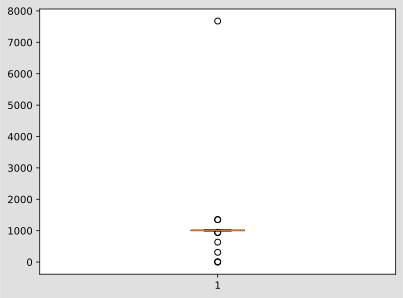

In [5]:
plt.boxplot(train['meanpressure'])

{'whiskers': [<matplotlib.lines.Line2D at 0x74de19cdf110>,
 'caps': [<matplotlib.lines.Line2D at 0x74de19cdf390>,
 'boxes': [<matplotlib.lines.Line2D at 0x74de19cdefd0>],
 'medians': [<matplotlib.lines.Line2D at 0x74de19cdf610>],
 'fliers': [<matplotlib.lines.Line2D at 0x74de19cdf750>],
 'means': []}

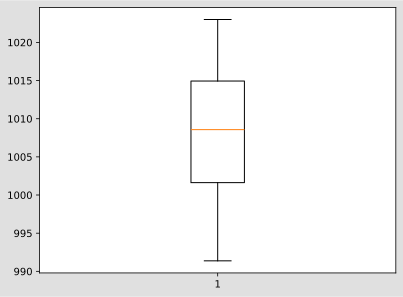

In [6]:
train = train[(980 < train['meanpressure']) & (train['meanpressure'] < 1200)]
plt.boxplot(train['meanpressure'])

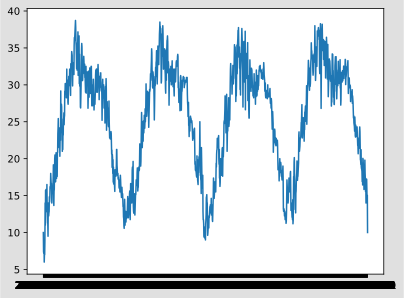

In [7]:
plt.plot(train['date'], train['meantemp'])

{'whiskers': [<matplotlib.lines.Line2D at 0x74de163eec10>,
 'caps': [<matplotlib.lines.Line2D at 0x74de163eee90>,
 'boxes': [<matplotlib.lines.Line2D at 0x74de163eead0>],
 'medians': [<matplotlib.lines.Line2D at 0x74de163ef110>],
 'fliers': [<matplotlib.lines.Line2D at 0x74de163ef250>],
 'means': []}

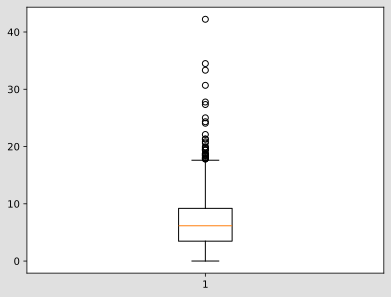

In [8]:
plt.boxplot(train['wind_speed'])

# Data preprocessing

In [9]:
def discret_temp(temp):

    for i in range(10,31,5):

        if temp < i:

            return i
    
    return 35

In [10]:
def discret_wind(speed):
    
    if speed < 5:
        return 0
    if speed < 10: 
        return 1
    if speed < 20:
        return 2
    return 3

In [11]:
def discretize_column(df, column):

    med = df[column].median()
    std = df[column].std()
    
    bins = [-np.inf, med - 1.5*std, med - 0.5*std, med + 0.5*std, med + 1.5*std, np.inf]
    
    labels = [-2, -1, 0, 1, 2]
    
    return pd.cut(df[column], bins=bins, labels=labels)

In [12]:
train['meantemp'] = train['meantemp'].apply(discret_temp)
train['wind_speed'] = train['wind_speed'].apply(discret_wind)
train['humidity'] = discretize_column(train, 'humidity')
train['meanpressure'] = discretize_column(train, 'meanpressure')

In [13]:
train

date  meantemp humidity  wind_speed meanpressure
0     2013-01-01        15        1           0            1
1     2013-01-02        10        2           0            1
2     2013-01-03        10        1           0            1
3     2013-01-04        10        1           0            1
4     2013-01-05        10        1           0            1
...          ...       ...      ...         ...          ...
1457  2016-12-28        20        0           0            1
1458  2016-12-29        20        2           1            1
1459  2016-12-30        15        2           1            1
1460  2016-12-31        20        1           1            1
1461  2017-01-01        15        2           0            1

[1453 rows x 5 columns]

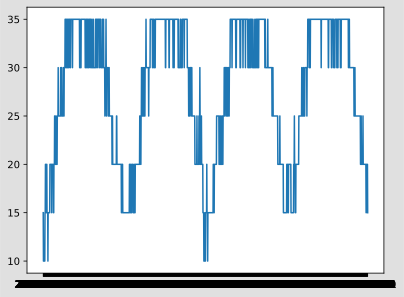

In [14]:
train.sort_index(inplace=True)
plt.plot(train['date'], train['meantemp'])

In [15]:
time_t = train.shift(-1).add_suffix("t")
train = train.add_suffix("0")
train = pd.concat([train, time_t], axis=1)
train.dropna(inplace=True)
train = train.drop(columns="datet")
train

date0  meantemp0 humidity0  wind_speed0 meanpressure0  meantempt  \
0     2013-01-01         15         1            0             1       10.0   
1     2013-01-02         10         2            0             1       10.0   
2     2013-01-03         10         1            0             1       10.0   
3     2013-01-04         10         1            0             1       10.0   
4     2013-01-05         10         1            0             1       10.0   
...          ...        ...       ...          ...           ...        ...   
1456  2016-12-27         20         0            1             1       20.0   
1457  2016-12-28         20         0            0             1       20.0   
1458  2016-12-29         20         2            1             1       15.0   
1459  2016-12-30         15         2            1             1       20.0   
1460  2016-12-31         20         1            1             1       15.0   

     humidityt  wind_speedt meanpressuret  
0            2          0.0             1  
1            1          0.0             1  
2            1          0.0             1  
3            1          0.0             1  
4            1          0.0             1  
...        ...          ...           ...  
1456         0          0.0             1  
1457         2          1.0             1  
1458         2          1.0             1  
1459         1          1.0             1  
1460         2          0.0             1  

[1452 rows x 9 columns]

In [16]:
types = {col : 'int64' for col in train.columns if col != 'date0'}
types['date0'] = 'object'

train = train.astype(types)
train


date0  meantemp0  humidity0  wind_speed0  meanpressure0  meantempt  \
0     2013-01-01         15          1            0              1         10   
1     2013-01-02         10          2            0              1         10   
2     2013-01-03         10          1            0              1         10   
3     2013-01-04         10          1            0              1         10   
4     2013-01-05         10          1            0              1         10   
...          ...        ...        ...          ...            ...        ...   
1456  2016-12-27         20          0            1              1         20   
1457  2016-12-28         20          0            0              1         20   
1458  2016-12-29         20          2            1              1         15   
1459  2016-12-30         15          2            1              1         20   
1460  2016-12-31         20          1            1              1         15   

      humidityt  wind_speedt  meanpressuret  
0             2            0              1  
1             1            0              1  
2             1            0              1  
3             1            0              1  
4             1            0              1  
...         ...          ...            ...  
1456          0            0              1  
1457          2            1              1  
1458          2            1              1  
1459          1            1              1  
1460          2            0              1  

[1452 rows x 9 columns]

# Apprentissage

In [17]:
template = gum.BayesNet()
for col in train.columns:
    if col == 'date0':
        continue
    template.add(gum.RangeVariable(col,col,int(np.min(train[col])), int(np.max(train[col]))))

learner = gum.BNLearner(train, template)

cols = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']

for col1 in cols:
    for col2 in cols:
        if col1 == 'date0' or col2 == 'date0':
            continue
        learner.addForbiddenArc(f"{col1}t", f"{col2}0")

bn = learner.learnBN()
bn

(pyAgrum.BayesNet@0x5d2dc3ab1de0) BN{nodes: 8, arcs: 8, domainSize: 10^6.82995, dim: 453, mem: 4Ko 224o}

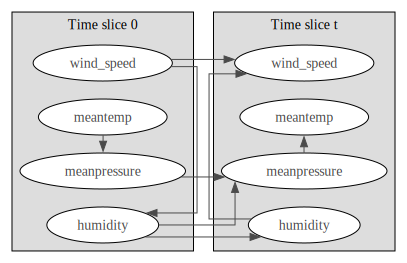

In [18]:
gdyn.showTimeSlices(bn)

# Test du modèle

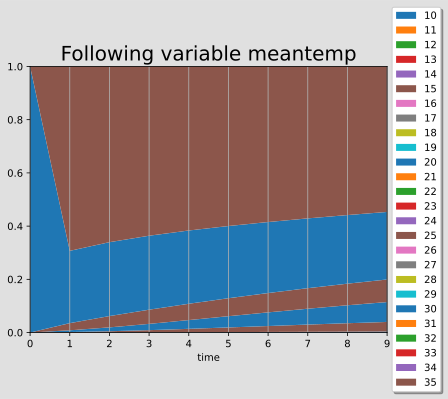

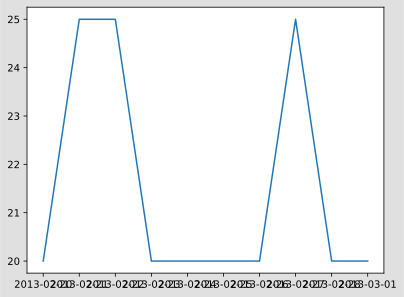

In [19]:
row = train.iloc[50]
ev = {f'{col}0' : int(row[f'{col}0']) for col in cols}

gdyn.plotFollow(["meantemp"],bn,T=10,evs=ev)
plt.plot(train.iloc[50:60]['date0'], train.iloc[50:60]['meantemp0'])